#Среда **Pendulum**

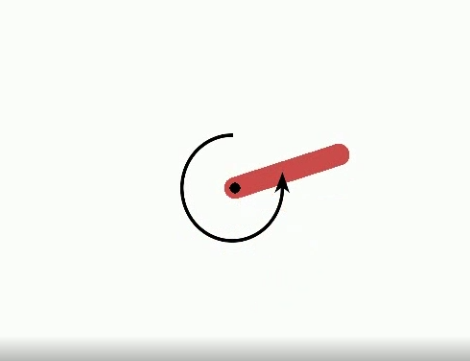

В данной среде есть маятник, который нужно держать в максимально высоком, вертикальном положении. Агент может управлять маятником через импульс (может толкать его влево или вправо).

Агент получает отрициательное вознаграждение за каждое действие, но чем ниже находиться маятник, тем ниже вознаграждение. В гипотетической ситуации где маятник распологается полностью вертикально на максимальной высоте, вознаграждение за состояние будет равна 0.

Данная среда относительно простая - размерность состояния равна всего 3, тем временем как размерность действий равна 1. Однако, все состояния и действия являются непрерывными. Именно по этому, мы будем использовать алгоритм **ГДГП** (Глубокая Детерминированна Градиентная Политика).

In [ ]:
#В связи с недавним обновлением библиотеки gym, попытки создать игровую среду pong-v0 (или любую другую) теперь вызывают ошибку. 
#Следующий код является временной мерой для избежание этой ошибки.

!pip install gym==0.18.0
!pip install atari-py==0.2.5
!pip install imageio==2.4.1

#Импортируем Библиотеки

In [ ]:
import gym         #Импортируем среду Gym
import numpy as np #Импортируем библиотеку NumPy
import tensorflow as tf                   #Импортируем Тензорфлоу
import math                               #Импортируем модуль для математических вычислений
from tensorflow.keras.models import Model #Импортируем класс для создания модели с кераса
from tensorflow.keras.layers import *     #Импортируем все слои с Кераса
from tensorflow.keras import utils        #Импортируем утилиты Кераса
from tensorflow.keras.optimizers import RMSprop, Adam #Импортируем оптимизаторы Кераса
from tensorflow.keras import backend as K #Импортируем бэкэнд Кераса
import time                               #Импортируем модуль который засекает время
import matplotlib.pyplot as plt           #Импортируем модуль для визуализации данных и создания графиков
import cv2                                #Импортируем библиотеку cv2 (нужна для создания видео)
from google.colab import output           #Импортируем функцию для управления вывода в колаб-ячейках

##Запускаем среду

Также, записываем размер пространства состояния (входная размерность сетей) и размерность пространства действий (выходная размерность сеи актёра) в переменные.

In [ ]:
env = gym.make("Pendulum-v0") #Создаем среду "маятник" - это среда с непрерывными действиями

state_space = env.observation_space.shape[0] #Записываем размер пространство состояния в переменную
action_space = env.action_space.shape[0]     #Записываем количество действий в среде

##Задаем Гиперпараметры

В коде ниже, мы поделили гиперпараметры на две категории. Первая категория содержит все гиперпараметры, которые нам уже хорош известны из предыдущих занятий.

Вторая категория содержит всего два новых гиперпараметра:

* **tau** - Этот гиперпараметр определяет скорость, с которой веса целевых моделей обновляется при обчуении сети. В отличии от алгоритма Q-обучения, мы не будем обновлять веса методом копирования весов основной модели - вместо этого, мы будем брать взвешенное значение между старыми весами целевых моделей и обученных весов основных моделей. Чем ближе этот параметр к 1, тем быстрее происходит обновление (см. функция *update_target_weights()* ниже).

* **standard_deviation** - Этот параметр определяет стандартное отклонение, с которым создается шум для исследования среды. Мы уже видели ктое-что очень похожее в предыдущем занятии по алгоритму БОП на непрерывных действий. Единственная разница - там был логарифм от ст. отклонение, а здесь можно использовать и обычное ст. отклонение.

In [ ]:
#Старые, известные нам гиперпараметры

gamma = 0.95                             #Гамма (параметр для передачи вознаграждений между состояний)
batch_size = 64                          #Размер батча при обучении
warmup_steps = 10 * batch_size           #Количество шагов исследования перед обучением сети
memory_size = 1e5                        #Размер буфера памяти
training_steps = 20000                   #Количество шагов за которое алгоритм обучается

#Новые гиперпараметры

tau = 0.995                              #Гиперпараметр τ - определяет скорость обновления весов целевых моделей через мягкий апдейт
standard_deviation = 0.4                 #Стандартное отклонение для шума (используется для исследования среды)

actor_optimizer = Adam(learning_rate = 1e-3)  #Оптимизатор актёра 
critic_optimizer = Adam(learning_rate = 2e-3) #Оптимизатор критика 

epsilon_decay_rate = 1/training_steps #Скорость снижения epsilon (считается по другим гиперпараметрам)

##Создаем архитектуру сетей

У нас четыре сети: основной и целевой актёр + основной и целевой критик.

Основные и целевые модели по определению имеют одинаковую архитектуру, также как в алгоритме Q-обучения. Они отличаются лишь в том, что целевая модель имеет другие и менее обученные веса. Также как в алогритме Q-обучения, это делается чтобы избежать проблему с переобучением.

Нужно отметить, что в алгоритме ГДГП критик имеет два входных слоя: для состояния и для действия. Суть заключается в том, что критик по сути возвращает Q(s, a) не для всех действий сразу, а только для одного действия - которое подалось сети на вход.

In [ ]:
#Задаем функцию, которая создает модель актёра
def create_actor_model():
  state_input = Input(shape = (state_space))            #У актёра один входной слой, который принимает на вход состояние среды
  x = Dense(256, activation = 'elu')(state_input)       #Создаем первый скрытый слой 
  x = Dense(64, activation = 'elu')(x)                  #Создаем второй скрытый слой 
  output = Dense(action_space, activation = 'tanh')(x)  #Создаем выходной слой (активационная функция гиперболического тангенса, 1 нейрон на выходе)
  output = Lambda(lambda x: 2*x)(output)                #Умножаем выход сети на 2, по скольку среда работает с действиями в диапазоне [-2, +2]
  model = Model(state_input, output)                    #Собираем модель из слоев
  return model                                          #Возвращаем модель из функции

#Задаем функцию, которая создает модель критика
def create_critic_model():
  state_input = Input(shape = (state_space))           #У критика два входных слоя, первый из которых принимает на вход состояние среды
  action_input = Input(shape = (action_space))         #Второй входной слой принимает на вход действие, которое предсказывает актёр

  x = Concatenate()([state_input, action_input])       #Склеиваем два входных массива вместе
  x = Dense(256, activation = 'elu')(x)                #Создаем первый скрытый слой
  x = Dense(64, activation = 'elu')(x)                 #Создаем второй скрытый слой                 
  output = Dense(1)(x)                                 #Выход критика всегда имеет 1 нейрон и активационную функцию linear
  model = Model([state_input, action_input], output)   #Собираем модель из слоев
  return model                                          #Возвращаем модель из функции

main_actor_model, target_actor_model = create_actor_model(), create_actor_model()      #Создаем основную и целевую модель актёра используя выше объявлянную функцию
main_critic_model, target_critic_model = create_critic_model(), create_critic_model()  #Создаем основную и целевую модель критика используя выше объявлянную функцию

target_actor_model.set_weights(main_actor_model.get_weights())                     #Приравниваем начальные веса основного и целевого актёра
target_critic_model.set_weights(main_critic_model.get_weights())                   #Приравниваем начальные веса основного и целевого критика

##Буфер Памяти

Алгоритм ГДГП использует буфер памяти, которое по сути ни чем не отличается от буфера памяти в алгоритме Q-обучения. Этот буфер хранит текущие состояния, следующие состояния, действия агента, вознаграждения, и статусы завершения эпизода.

Код ниже предоставляет альтернативный код для создания этого буфера памяти. По скольку здесь используются не циклы, а numpy маски для сбора данных, данный код выполняется быстрее.

In [ ]:
#Создаем класс буфера памяти
class Memory_Buffer: #Метод создания объекта принимает на вход размер буфера памяти и размер пакетов, которые будут извлекаться из памяти
  def __init__(self, memory_size = 1e5, batch_size = 128):
    self.buffer_counter = 0              #Счетчик, с которым мы будем считать индекс куда записывать новые данные (инициализируется как 0)
    self.memory_size = int(memory_size)  #Записываем размер буфера памяти
    self.batch_size = batch_size         #Записываем размер пакетов которые извлекаются из буфера

    self.current_state_buffer = np.zeros((self.memory_size, state_space))    #Создаем буфер для текущих состояний
    self.next_state_buffer = np.zeros((self.memory_size, state_space))       #Создаем буфер для следующих состояний
    self.action_buffer = np.zeros((self.memory_size, action_space))          #Создаем буфер для действий
    self.reward_buffer = np.zeros((self.memory_size, 1))                     #Создаем буфер для вознаграждений
    self.done_buffer = np.zeros((self.memory_size, 1))                       #Создаем буфер для статусов завершения эпизода

  #Метод для добавления новых данных в объект
  #Принимает на вход текущее состояние, следующее состояние, дейвстие, вознаграждение, и статус завершения игры
  def add_to_memory(self, current_state, next_state, action, reward, done): 
    index_to_write = self.buffer_counter % self.memory_size                #Считаем индекс, куда записывать новые данные

    self.current_state_buffer[index_to_write, :] = current_state.squeeze() #Записываем текущее состояние в буфер памяти (удаляем лишние размерности)
    self.next_state_buffer[index_to_write, :] = next_state.squeeze()       #Записываем следующее состояние в буфер памяти (удаляем лишние размерности)
    self.action_buffer[index_to_write, :] = action                         #Записываем действие агента в буфер памяти (удаляем лишние размерности)
    self.reward_buffer[index_to_write, :] = float(reward)                  #Записываем полученное вознаграждение в буфер памяти (удаляем лишние размерности)
    self.done_buffer[index_to_write, :] = int(done)                        #Записываем статус завершения эпизода в буфер памяти (удаляем лишние размерности)
    
    self.buffer_counter += 1                                               #Увеличиваем счетчик на 1

  #Метод для извлечения пакета данных для обучения сети. Данные переводяться в тензоры для быстрого обучения алгоритма.
  def retrieve_memory(self):
    filled_memory_size = min(self.memory_size, self.buffer_counter) #Считаем, сколько сэмплов данных содержится в датасете
    batch_indices = np.random.randint(0, max(batch_size, filled_memory_size), self.batch_size) #Рандомным образом извлекаем индексы по которым извлекаем данные
    batch_current_states = tf.convert_to_tensor(self.current_state_buffer[batch_indices], dtype = tf.float32) #Извлекаем пакет текущих состояний среды
    batch_next_states = tf.convert_to_tensor(self.next_state_buffer[batch_indices], dtype = tf.float32)       #Извлекаем пакет следующих состояний среды
    batch_actions = tf.convert_to_tensor(self.action_buffer[batch_indices], dtype = tf.float32)               #Извлекаем пакет действий
    batch_rewards = tf.convert_to_tensor(self.reward_buffer[batch_indices], dtype = tf.float32)               #Извлекаем пакет вознаграждений
    batch_dones = tf.convert_to_tensor(self.done_buffer[batch_indices], dtype = tf.float32)                   #Извлекаем пакет статусов завершения эпизода

    return batch_current_states, batch_next_states, batch_actions, batch_rewards, batch_dones                 #Возвращаем все данные 

memory_buffer = Memory_Buffer(memory_size, batch_size) #Создаем объект буфера памяти

##Создаем функции для обучения алгоритма

В блоке ниже предоставлены три функции, но только одна из этих функций является основной. Нужно отметить, что код написан на тензорфлоу не только для ускорения обучения, но и потому что керасовские `model.fit()` и `model.train_on_batch()` не подходят для обучения такой сети.

Функция `train_tensorflow` имеет обёртку `@tf.function` которая позволяет коду выполняться намного быстрее. Однако, в результате применения этой обёртки (которая требует чтобы внутри функции был только код тензорфлоу), часть кода должна лежать в отдельной функции без обёртки. Экспериментами доказано, что если код из функции `train_algorithm` вместить в функцию `train_tensorflow`, код будет работать криво и сеть не будет обучаться.

Функция `update_target_weights` используется для обучения целевых моделей. Она также имеет обёртку `@tf.function`, которая позволяет коду выполняться быстрее но требует чтобы весь код внутри функции был написан через синтаксис библиотеки тензорфлоу.  

In [ ]:
#Функция для обучения сети - принимает на вход данные из буфера памяти (использует обёртку для ускорения @tf.function)
@tf.function
def train_tensorflow(batch_current_states, batch_next_states, batch_actions, batch_rewards, batch_dones):
  with tf.GradientTape() as tape: #Считаем градиенты для обучения модель критика:
    target_actions = target_actor_model(batch_next_states)                                          #Подаем следующее состояния в модель целевого актёра, чтобы получить действие
    critic_Q_value = target_critic_model([batch_next_states, target_actions])                       #Считаем значения Q(s, a) от критика (считаются значения по действиям которые предсказывает целевой актёр) - лейблы 
    unrolled_rewards = batch_rewards + (1 - batch_dones) * gamma * critic_Q_value                   #Применяем уравнение Бэллмена для дисконтирования вознаграждений
    critic_value = main_critic_model([batch_current_states, batch_actions])                         #Подаем текущие состояния в модель критика чтобы получить Q(s, a) - предсказание модели
    critic_loss = tf.math.reduce_mean(tf.math.square(unrolled_rewards - critic_value))              #Считаем лосс критика используя среднеквадратичную ошибку
  
  critic_gradients = tape.gradient(critic_loss, main_critic_model.trainable_variables)              #Считаем градиенты по ошибки критика
  critic_optimizer.apply_gradients(zip(critic_gradients, main_critic_model.trainable_variables))    #Применяем градиенты к модели - т.е. обучаем сеть

  with tf.GradientTape() as tape: #Считаем градиенты для обучения модель актёра:
    predicted_actions = main_actor_model(batch_current_states)                                      #Подаем ткущие состояния в актёр, получаем действия агента
    critic_value = main_critic_model([batch_current_states, predicted_actions])                     #Считаем значения Q(s, a) от критика по действиям a, которые предсказал актёр
    actor_loss = -tf.math.reduce_mean(critic_value)                                                 #Актёр пытается максимизировать значение критика

  actor_gradients = tape.gradient(actor_loss, main_actor_model.trainable_variables)                 #Считаем градиенты по ошибки актёра
  actor_optimizer.apply_gradients(zip(actor_gradients, main_actor_model.trainable_variables))       #Применяем градиенты к модели - т.е. обучаем сеть

  update_target_weights(main_actor_model.variables, target_actor_model.variables)                   #Обновляем веса целевого актёра используя метод мягкого обновления
  update_target_weights(main_critic_model.variables, target_critic_model.variables)                 #Обновляем веса целевого критика используя метод мягкого обновления

#Функция для обучения сети - извлекает данные из буфера памяти и подает них в выше-объявленную функцию
def train_algorithm():
  batch_current_states, batch_next_states, batch_actions, batch_rewards, batch_dones = memory_buffer.retrieve_memory() #Извлекаем данные из буфера памяти
  train_tensorflow(batch_current_states, batch_next_states, batch_actions, batch_rewards, batch_dones)                 #Подаем данные в модель для её обучения

#Объявляем функцию для мягкого обновления весов целевых моделей.
#Данная функция вызовается в каждом моменте обучения, но каждый раз всего "немного" обновляет веса. 
#Это делается, чтобы целевые модели отличались от основных, но всё таки обновлялись в каждой итерации обучения.
@tf.function
def update_target_weights(main_weights, target_weights): #Функция принимает на вход веса основной модели и целевой модели
  for (main, target) in zip(main_weights, target_weights):       #В цикле проходимся по весам и смещениям каждого слоя
    target.assign(tau * target + (1 - tau) * main)               #Делаем "мягкое" обновление с гиперпараметром tau

##Функция для выбора действия

Данная функция принимает на вход состояние среды и значение эпсилон. Состояние подается на вход модели чтобы получить действие из непрерывного пространства действий. К действию затем добавяется шум для исследования среды.

Итоговое действие срезается в диапазоне [-2, +2] потому что данная среда `Pendulum-v0` работает с этим диапазоном. 

In [ ]:
#Функция для выбора действия - принимает на вход состояние среды и параметр для создания шума epsilon
def choose_action(state, epsilon):
  state = tf.expand_dims(tf.convert_to_tensor(state.squeeze(), dtype = tf.float32), axis = 0) #Предобрабатываем состояние чтобы был тензор с размерностью [1, 3]
  predicted_action = tf.squeeze(main_actor_model(state)).numpy()                              #Получаем действие и переводим в numpy-массив и удаляем лишнюю размерность с единицой
  predicted_action += epsilon * np.random.normal(0, standard_deviation, size = action_space)  #Добавляем шум к предсказанному действию (шум задается с гиперпараметром standard_deviation и параметром epsilon)
  final_action = np.clip(predicted_action, -2, 2)                                             #Сжимаем действие в диапазон [-2, +2] чтобы оно соответствовало диапазону среды

  return final_action                                                                         #Возвращаем итоговое действие из функции

##Функция для отображения вознаграждений

Две функции которые указаны ниже нам уже хорошо знакомы. Первая функция будет создавать графики с вознаграждениями и скользящими средними от вознаграждений, тем временем как вторая функция является воспомогательной и будет считать скользящее среднее.

In [ ]:
#Создаем функцию для визуализации результата - принимает на вход массив вознаграждений за все эпизоды
def plot_results(rewards):
  output.clear() #Удаляем предидущий вывод ячейки
  plt.figure(figsize = (16, 10)) #Делаем размер графика большим
  plt.plot(rewards, color = 'blue', label = "Вознаграждения за эпизод (сырая)")                                                 #Отрисовываем вознаграждения за эпизоды
  plt.plot(moving_average(rewards), color = 'green', linestyle = '--', label = "Вознаграждения за эпизод (скользящая средняя)") #Отрисовываем скользящие средние вознаграждения
  plt.xlabel("Эпизод", fontsize = 14)                                                                                           #Добавляем лейбл для оси х
  plt.title("История наград во время обучения", fontsize = 20)                                                                  #Добавляем заголовок

  plt.legend()        #Отображаем легенду
  plt.show()          #Отображаем график

#Также мы создадим функцию для подсчета скользящего среднего всех значений.
#Это будет осуществляться через матиматическую свёртку, и мы будем считать скользящее среднее за 10 значений.

def moving_average(data, width = 10): #data - входной массив, width - длина на которое считаем скользящее среднее.
  width = min(width, len(data))       #Длина свёртки (минимум из заданной длины свёртки и длины датасета)
  data = np.concatenate([np.repeat(data[0], width), data])         #Вместо паддинга из нулей, мы создадим паддинг для свёртки из первого значения массива. Весь паддинг будет слева (в начале массива)
  return (np.convolve(data, np.ones(width), 'valid') / width)[1:]  #Возвращаем результат свёртки данных на фильтр из единиц - наше скользящее среднее

##Создаем цикл для обучения игры

Ниже представленный код запускает среду и обучает агента на каждом шаге. 

Нужно отметить, что данная среда простая и её код выполняется быстро - по этому, агент обучается относительно быстро. Именно по этому, у нас не будет бесконечный цикл, а обучение будет плавно продолжаться пока значение параметра `epsilon` выше 0.

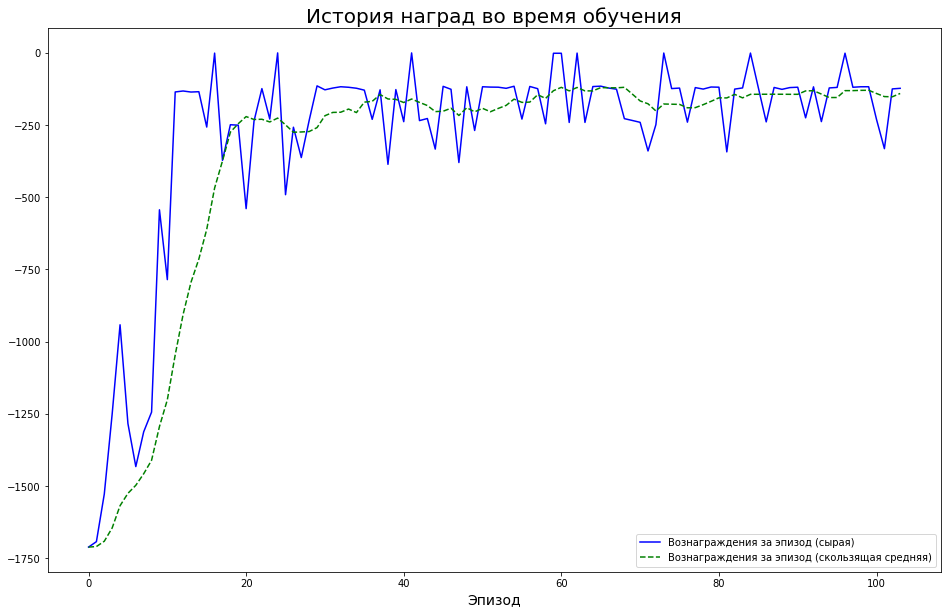

Завершен 104-й эпизод, значения эпсилон равно 0.002079999999727501, суммарное вознаграждение равно -122.98175096584038.


In [ ]:
episode_rewards = []   #Инициализируем пустой список, где будем хранить суммарное вознаграждение за каждый эпизод
epsilon = 1            #Инициализируем параметр epsilon с значением 1
total_duration = 0     #Инициализируем параметр, который считает суммарное количество действий за все эпизоды

while epsilon > 0:     #Создаем цикл который будет прогоняться пока у epsilon значение выше 0
  episode_reward = 0   #Инициализируем сумму вознаграждений за эпизод как 0
  done = False         #Указываем что эпизод пока не завершен
  current_state = env.reset()  #Начинаем новый эпизод и получаем первоначальное состояние
  while not done:              #Создаем внутренний цикл, который играет до конца эпизода
    action = choose_action(current_state, epsilon)    #Извлекаем действие агента по состоянию и значению epsilon
    next_state, reward, done, info = env.step(action) #Подаем действие в среду и извлекаем новое состояние, вознаграждение, и статус завершения эпизода
    memory_buffer.add_to_memory(current_state, next_state, action, reward, done) #Добавляем все нужные данные (текущее состояние, следующее состояние, действие, вознаграждение, и статус заверешния эпизода) в буфер памяти
    
    episode_reward += float(reward) #Добавляем вознаграждение для подсчета суммы вознаграждений
    total_duration += 1             #Увеличиваем счетчик количество действий на 1

    if total_duration > warmup_steps: #Если мы приняли достаточно действий чтобы начать обучение:
      train_algorithm()               #Обучаем алгоритм (после каждого шага)
      epsilon -= epsilon_decay_rate   #Снижаем значение параметра epsilon (чтобы на следующем шаге было меньше шума исследования среды)

    current_state = next_state        #Записываем текущее состояние как следующее состояние
  
  episode_rewards.append(episode_reward) #В конце эпизода - добавляем суммарное вознаграждение за эпизод в соответствующий список

  plot_results(episode_rewards)          #Отображаем график с суммами всех вознаграждений за все эпизоды
  
  print(f"Завершен {len(episode_rewards)}-й эпизод, значения эпсилон равно {epsilon}, суммарное вознаграждение равно {episode_reward}.")

# Записываем результат работы сети в видео

Сперва, нам нужно установить несколько зависимостей которые позволят отображать состояние среды в виде картинки.

Весь код для установки зависимостей/создания дисплея является шаблонным - его не нужно тщательно изучать или запомянать синтаксис.

In [ ]:
#Устанавливаем зависимости
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
import pyvirtualdisplay #Импортируем библиотеку которая позволит создать дисплей


_display = pyvirtualdisplay.Display(visible=False, size=(1400, 900)) #Создаем дисплей где будем отображать кадры
_ = _display.start() #Запускаем дисплей

##Играем в эпизод, создаем видео с игрой

In [ ]:
env = gym.make("Pendulum-v0") #Создаем среду
video_frames = []             #Инициализируем пустой список где будем хранить кадры состояния среды
state = env.reset()           #Начинаем новый эпизод и получаем первоначальное состояние
done = False                  #Указываем что эпизод пока не завершен
while not done:               #Создаем внутренний цикл, который играет до конца эпизода
  video_frames.append(env.render(mode='rgb_array')) #Добавляем текущий кадр в соответствующий массив
  action = choose_action(state, epsilon = 0)        #Выбираем действие по текущему состоянию - указываем эпсилон как 0 чтобы не добавлять шум
  state, reward, done, info = env.step(action)      #Подаем предсказанное действие в среду
env.close() #Закрываем среду в конце эпизода

out = cv2.VideoWriter('/content/episode.avi', cv2.VideoWriter_fourcc(*'DIVX'), 30, (500, 500)) #Создаем объект для воспроизведениед видео (задаем путь к файлу видео, формат видео, кадры в секунду, и размер изображений)
for i in range(len(video_frames)):  #В цикле добавляем каждый кадр в видео (делаем предобработку кадра - меняем каналы с RGB в BGR - это нужно потому что cv2 воспринимает каналы как BGR) 
  out.write(cv2.cvtColor(video_frames[i], cv2.COLOR_RGB2BGR))
out.release()                       #Закрываем объект для создания видео

from moviepy.editor import VideoFileClip #Импортируем объект для отображения видео в колабе

clip=VideoFileClip("/content/episode.avi")  #Извлекаем видео из заданного пути (куда мы ранее записыли видео через cv2)  
clip.ipython_display(width = 480, maxduration = 20) #Отображаем видео в колабе

100%|██████████| 201/201 [00:00<00:00, 244.66it/s]
